In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#add_model.add(Flatten())
add_model.add(Dense(4096, activation='relu'))
add_model.add(Dense(4096, activation='relu'))
add_model.add(Dense(11, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.summary()

batch_size = 8

epochs = 5
nb_train_samples = 29700
nb_validation_samples =3300
# dimensions of our images.
img_width, img_height = 224, 224

# prepare data augmentation configuration
data_generator = ImageDataGenerator(rescale=1. / 255 , validation_split=0.1)


train_data_dir = '/home/serevr/Desktop/NASNET/Class11(224)'


train_generator = data_generator.flow_from_directory(
   train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size, shuffle=True, seed=13,subset="training",
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size, shuffle=False, seed=13,subset="validation",
    class_mode='categorical')


Y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

top_values, top_indices = K.get_session().run(tf.nn.top_k(y_pred, k= 5))

# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


# fine-tune the model
history = model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    #samples_per_epoch=3712,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=412
    #nb_val_samples=nb_validation_samples
    )

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/serevr/anaconda3/envs/en1/lib/python3.5/site-packages/ipykernel_launcher.py:75: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/serevr/anaconda3/envs/en1/lib/python3.5/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=5, steps_per_epoch=3712, validation_steps=412, validation_data=<keras.pre...)`


Epoch 1/5
3712/3712 [==============================] - 653s 176ms/step - loss: 0.3878 - acc: 0.8650 - top_k_categorical_accuracy: 0.9904 - val_loss: 0.1845 - val_acc: 0.9372 - val_top_k_categorical_accuracy: 0.9994
Epoch 2/5
3712/3712 [==============================] - 642s 173ms/step - loss: 0.1146 - acc: 0.9610 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.2154 - val_acc: 0.9205 - val_top_k_categorical_accuracy: 0.9997
Epoch 3/5
3712/3712 [==============================] - 642s 173ms/step - loss: 0.0483 - acc: 0.9840 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1528 - val_acc: 0.9457 - val_top_k_categorical_accuracy: 0.9997
Epoch 4/5
3712/3712 [==============================] - 642s 173ms/step - loss: 0.0240 - acc: 0.9929 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1362 - val_acc: 0.9508 - val_top_k_categorical_accuracy: 0.9991
Epoch 5/5
3712/3712 [==============================] - 643s 173ms/step - loss: 0.0109 - acc: 0.9975 - top_k_categorical_accuracy: 1.0000 - v

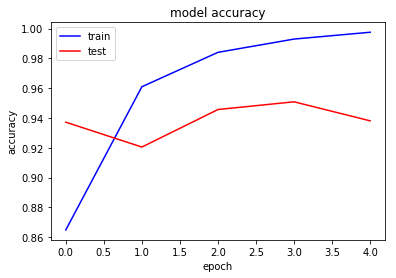

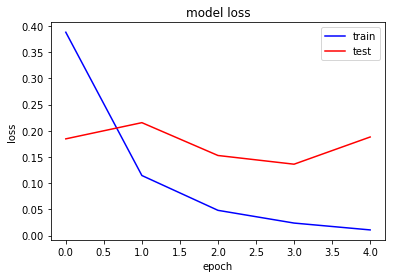

In [2]:
#ploting the graphs to see the loss and accuracy curves
acc=history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.figure()

plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.figure()

plt.show()

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
%matplotlib inline
import itertools

#confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Boat', 'Bus','Car','Motorcycle','Planes','Suv','Tractor','Trailer','Train', 'Truck', 'Van']
print(classification_report(validation_generator.classes, y_pred, target_names = target_names))

Confusion Matrix
[[298   0   0   0   1   0   0   0   1   0   0]
 [  0 295   0   0   0   0   0   0   3   2   0]
 [  0   0 284   1   1  11   0   0   2   1   0]
 [  0   0   0 300   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0]
 [  0   0  52   0   0 224   0   0   0   0  24]
 [  0   3   0   1   0   0 289   5   0   2   0]
 [  0   1   0   0   0   0   0 294   2   2   1]
 [  0   1   0   0   0   0   0   0 299   0   0]
 [  0   0   1   0   0  20   0   0   0 275   4]
 [  0   2  27   0   0  31   0   0   0   4 236]]
Classification Report
              precision    recall  f1-score   support

        Boat       1.00      0.99      1.00       300
         Bus       0.98      0.98      0.98       300
         Car       0.78      0.95      0.86       300
  Motorcycle       0.99      1.00      1.00       300
      Planes       0.99      1.00      1.00       300
         Suv       0.78      0.75      0.76       300
     Tractor       1.00      0.96      0.98       300
     Trail